In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import sys
import pathlib

In [5]:
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import the local package 

In [6]:
sys.path.append('../../')

In [7]:
from ICU_Water_Watch import plot, utils, GPM, geo

### first step, we update the local GPM-IMERG dataset on disk, which is in by default `/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP`

In [8]:
GPM.update()

Last downloaded file in /home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP is GPM_IMERG_daily.v06.2021.07.28.nc

trying to download GPM_IMERG_daily.v06.2021.07.29.nc in /home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP

! file size for input file 3B-DAY-L.MS.MRG.3IMERG.20210729-S000000-E235959.V06.nc4 is too small, netcdf file GPM_IMERG_daily.v06.2021.07.29.nc is not yet available to download from https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGDL.06/2021/07



In [9]:
ndays = 90

In [10]:
dpath_realtime = CWD.parents[5] / 'ops/data/GPM_IMERG/daily/extended_SP'

In [11]:
lfiles = GPM.get_files_list(dpath = dpath_realtime, ndays=ndays, lag=2)

In [12]:
dset = GPM.make_dataset(lfiles, ndays=ndays)

In [13]:
dset

<xarray.Dataset>
Dimensions:           (lat: 300, lon: 460, time: 90)
Coordinates:
  * time              (time) object 2021-04-30 00:00:00 ... 2021-07-28 00:00:00
  * lat               (lat) float64 -49.88 -49.62 -49.38 ... 24.38 24.62 24.88
  * lon               (lon) float64 125.1 125.4 125.6 ... 239.4 239.6 239.9
Data variables:
    precipitationCal  (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>
Attributes:
    BeginDate:       2021-04-30
    BeginTime:       00:00:00.000Z
    EndDate:         2021-04-30
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2021-04-30T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20210430-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2021-05-01T14:44:20.228Z
    ndays:           90
    last_day:        2021-07-28

### get the last date and the number of days in the dataset, which are created automatically as global attributes in the dataset 

In [14]:
last_date, ndays_dset  = GPM.get_attrs(dset)

In [15]:
last_date

datetime.datetime(2021, 7, 28, 0, 0)

In [16]:
ndays_dset

90

In [17]:
dset

<xarray.Dataset>
Dimensions:           (lat: 300, lon: 460, time: 90)
Coordinates:
  * time              (time) object 2021-04-30 00:00:00 ... 2021-07-28 00:00:00
  * lat               (lat) float64 -49.88 -49.62 -49.38 ... 24.38 24.62 24.88
  * lon               (lon) float64 125.1 125.4 125.6 ... 239.4 239.6 239.9
Data variables:
    precipitationCal  (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>
Attributes:
    BeginDate:       2021-04-30
    BeginTime:       00:00:00.000Z
    EndDate:         2021-04-30
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2021-04-30T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20210430-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2021-05-01T14:44:20.228Z
    ndays:           90
    last_day:        2021-07-28

### extract a "virtual station" from the dataset 

#### we choose Honiara (Solomon Islands) as an example 

In [18]:
station_name = 'Honiara'
lon = 159.9729
lat = -9.4456

#### the function also returns the extracted coordinates, and the distance to the actual coordinates passed, in km 

In [19]:
df, extracted_coords, dist = GPM.get_virtual_station(dset, lat=lat, lon=lon)

In [20]:
df.head()

,observed
2021-04-30,2.663119
2021-05-01,11.338182
2021-05-02,2.612749
2021-05-03,2.369642
2021-05-04,0.603128


In [21]:
extracted_coords

(159.875, -9.375)

In [22]:
dist

13.151756515016995

#### we now extract the daily climatology (default file name is `daily_climatology_5days_rm_2001_2020.nc`, calculated in `notebooks/GPM/calculates_GPM-IMERG_daily_climatologies.ipynb`)

In [23]:
dpath_climatology = CWD.parents[5] / 'ops/data/GPM_IMERG/daily/extended_SP/CLIMATOLOGY'

In [24]:
clim = GPM.get_virtual_station_climatology(dpath=dpath_climatology, lat=lat, lon=lon)

In [25]:
df = GPM.join_clim(df, clim)

In [26]:
df.head()

,observed,climatology
2021-04-30,2.663119,5.502243
2021-05-01,11.338182,4.600376
2021-05-02,2.612749,4.098305
2021-05-03,2.369642,4.890831
2021-05-04,0.603128,5.096645


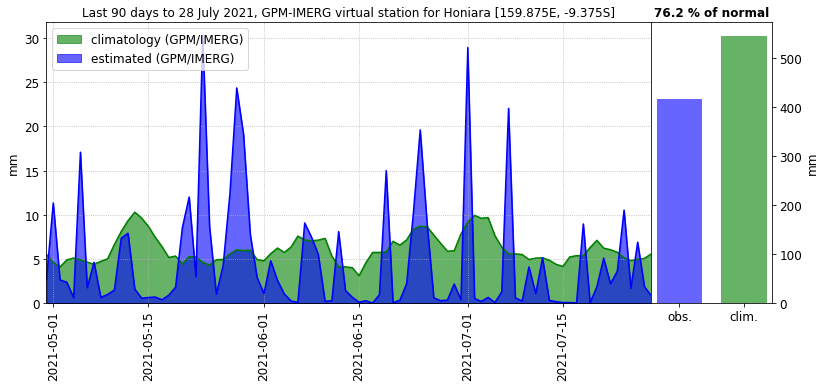

In [27]:
f = plot.plot_virtual_station(df, station_name=station_name, lon=extracted_coords[0], lat=extracted_coords[-1])

### calculate the rainfall accumulation over the past N days 

In [28]:
dset_accum = GPM.calculate_realtime_accumulation(dset)

In [29]:
dset_accum.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:           (lat: 300, lon: 460, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2021-07-28
  * lat               (lat) float64 -49.88 -49.62 -49.38 ... 24.38 24.62 24.88
  * lon               (lon) float64 125.1 125.4 125.6 ... 239.4 239.6 239.9
Data variables:
    precipitationCal  (time, lat, lon) float64 315.2 311.6 304.0 ... 8.947 8.843
Attributes:
    BeginDate:       2021-04-30
    BeginTime:       00:00:00.000Z
    EndDate:         2021-04-30
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2021-04-30T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20210430-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2021-05-01T14:44:20.228Z
    ndays:           90
    last_day:        2021-07-28>

### get the rain days stats: number of rain days (threshold = 1 mm/day), number of dry days, and number of days since last rain

In [30]:
dset_ndays = GPM.get_rain_days_stats(dset)

In [31]:
dset_ndays.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:          (lat: 300, lon: 460, time: 1)
Coordinates:
  * time             (time) datetime64[ns] 2021-07-28
  * lat              (lat) float64 -49.88 -49.62 -49.38 ... 24.38 24.62 24.88
  * lon              (lon) float64 125.1 125.4 125.6 125.9 ... 239.4 239.6 239.9
Data variables:
    wet_days         (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>
    dry_days         (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>
    days_since_rain  (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>
Attributes:
    ndays:     90
    last_day:  2021-07-28>

### get the climatology, for the calculation of the anomalies 

In [32]:
clim = GPM.get_climatology(dpath=dpath_realtime, ndays=ndays, date=last_date)

### calculates the anomalies and the percentages of scores, and insert the resulting variables (`anoms` and `pctscore`) in the dataset 

In [33]:
dset_accum = GPM.calc_anoms_and_pctscores(dset_accum, clim)

In [34]:
dset_accum.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:           (lat: 300, lon: 460, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2021-07-28
  * lat               (lat) float64 -49.88 -49.62 -49.38 ... 24.38 24.62 24.88
  * lon               (lon) float64 125.1 125.4 125.6 ... 239.4 239.6 239.9
Data variables:
    precipitationCal  (time, lat, lon) float64 315.2 311.6 304.0 ... 8.947 8.843
    pctscore          (time, lat, lon) float64 9.0 5.0 5.0 ... 37.0 43.0 43.0
    anoms             (time, lat, lon) float64 -134.0 -136.6 ... -8.381 -10.14
Attributes:
    BeginDate:       2021-04-30
    BeginTime:       00:00:00.000Z
    EndDate:         2021-04-30
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2021-04-30T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20210430-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IM

### get the EEZs for each country, and a dissolved version for the mask 

In [35]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes='/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/')

### insert the mask in each dataset 

In [36]:
dset_accum = geo.make_mask_from_gpd(dset_accum, merged_EEZs, subset=True, mask_name='EEZ')

In [37]:
dset_ndays = geo.make_mask_from_gpd(dset_ndays, merged_EEZs, subset=True, mask_name='EEZ')

In [38]:
dset_accum.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:           (lat: 220, lon: 439, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2021-07-28
  * lat               (lat) float64 -30.88 -30.62 -30.38 ... 23.38 23.62 23.88
  * lon               (lon) float64 129.4 129.6 129.9 ... 238.4 238.6 238.9
Data variables:
    precipitationCal  (time, lat, lon) float64 108.4 105.6 95.44 ... 5.01 4.685
    pctscore          (time, lat, lon) float64 85.0 80.0 75.0 ... 18.0 13.0 14.0
    anoms             (time, lat, lon) float64 32.18 29.25 ... -9.585 -11.74
    EEZ               (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    BeginDate:       2021-04-30
    BeginTime:       00:00:00.000Z
    EndDate:         2021-04-30
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2021-04-30T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20210430-S000000-E002959.0000.V06...
    title:           GPM IMERG Late

### Plots the precipitation anomalies 

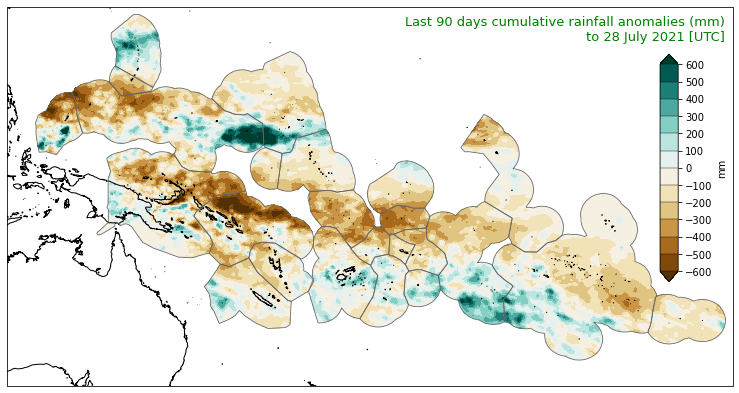

In [39]:
plot.map_precip_anoms(dset_accum, mask='EEZ', close=False, geoms=EEZs, fpath='.')

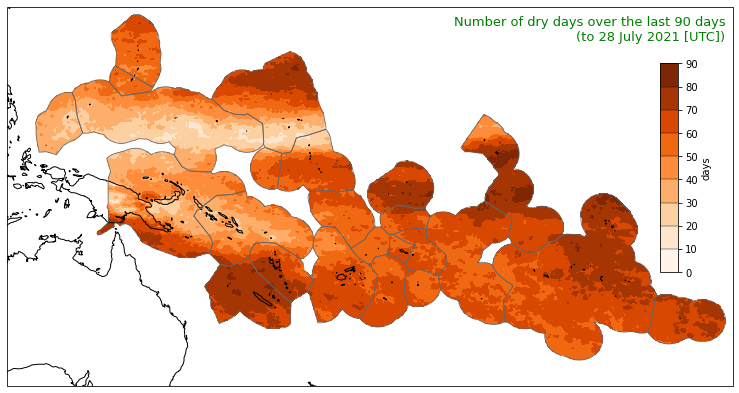

In [40]:
plot.map_dry_days_Pacific(dset_ndays, mask='EEZ', geoms=EEZs, close=False)

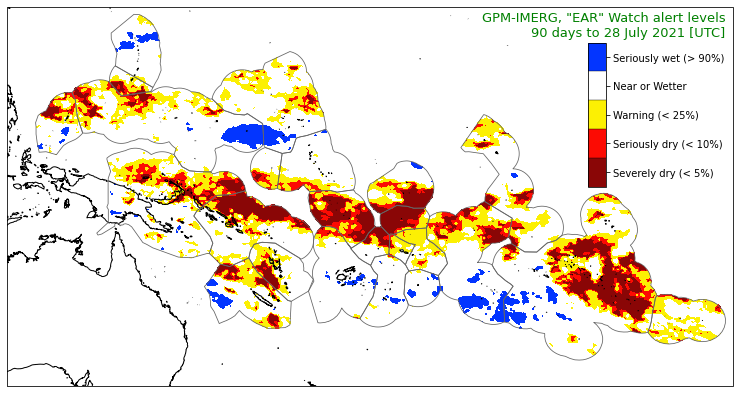

In [41]:
plot.map_EAR_Watch_Pacific(dset_accum, mask='EEZ', geoms=EEZs, close=False, fpath='.')

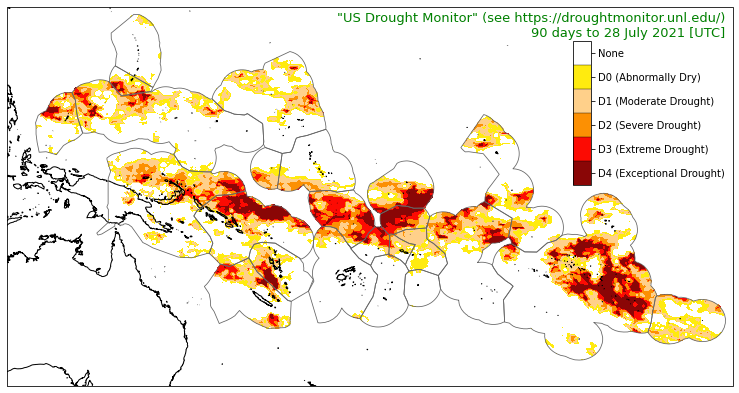

In [42]:
plot.map_USDM_Pacific(dset_accum, mask='EEZ', geoms=EEZs, close=False, fpath='.')

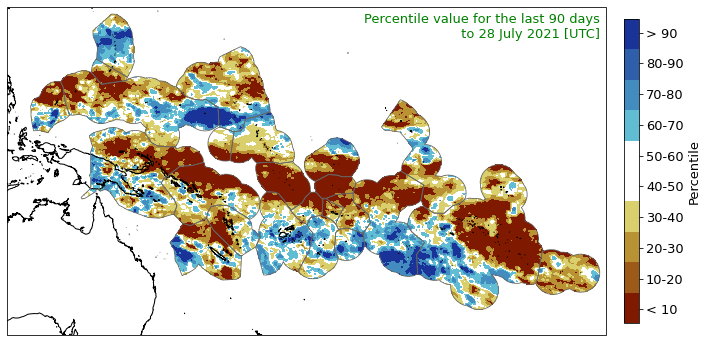

In [43]:
plot.map_decile(dset_accum, mask='EEZ', geoms=EEZs, close=False, fpath='.')

### creates on dataset per country, including the EEZ mask 

In [44]:
for i, country_name in enumerate(EEZs.COUNTRYNAM): 
    c = EEZs.query(f"COUNTRYNAM == '{country_name}'")
    sub = geo.make_mask_from_gpd(dset_accum, c, mask_name='mask_EEZ')

In [45]:
country_name

'French Polynesia'

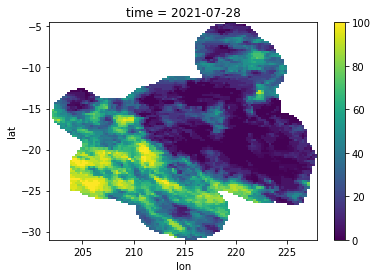

In [46]:
(sub['pctscore'] * sub['mask_EEZ']).squeeze().plot()